In [1]:
%matplotlib inline

import hamiltorch
import sbibm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import zuko
from copy import deepcopy
import sys

from itertools import islice
from tqdm import tqdm

from lampe.data import JointLoader, JointDataset, H5Dataset
from lampe.inference import NRE, NRELoss, BNRELoss
from dnre.inference import *


from lampe.plots import nice_rc, corner, mark_point, coverage_plot
from lampe.utils import GDStep

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
path = '../data/data_dict_4490'
dic = torch.load(path)

thetas_full = torch.tensor(dic['theta']).float()
xs_full = torch.tensor(dic['x']).float()

thetas_mean = thetas_full.mean(0)
xs_mean = xs_full.mean(0)

thetas_std = thetas_full.std(0)
xs_std = xs_full.std(0)

thetas_full_norm = (thetas_full - thetas_mean) / thetas_std
xs_full_norm = (xs_full - xs_mean) / xs_std

D_in = thetas_full_norm.shape[1]
D_out = xs_full_norm.shape[1]

train_N = int(0.8 * thetas_full_norm.shape[0]) # Already in a random order


dataset = JointDataset(thetas_full_norm[:train_N], xs_full_norm[:train_N], batch_size=512, shuffle=True)
dataset_val = JointDataset(thetas_full_norm[train_N:], xs_full_norm[train_N:], batch_size=512, shuffle=False)


LABELS = []
for r in range(D_in):
    LABELS.append(r'$\theta_' + str(r) + r'$')

LOWER = torch.min(thetas_full_norm,0)[0]
UPPER = torch.max(thetas_full_norm,0)[0]


# Set the prior for the parameters
prior = MultivariateUniform(low = LOWER.numpy(), high = UPPER.numpy())

### Training:

In [3]:
hidden_features = 128
layers = 5
lr = 1e-3
epochs = 2000
# Validation kept going down
epochs_dnre = 10000
load = False
save = True

#### NRE

In [4]:
hamiltorch.set_random_seed(0)
estimator_nre = NRE(D_in, D_out, hidden_features=[hidden_features] * layers, activation=nn.ELU).to(device)
estimator_nre, loss_list_nre, val_loss_list_nre = train_estimator(estimator_nre, NRELoss, epochs, dataset, dataset_val, lr, device)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:59<00:00, 16.74epoch/s, loss=2.72e-5, val=0.000387]


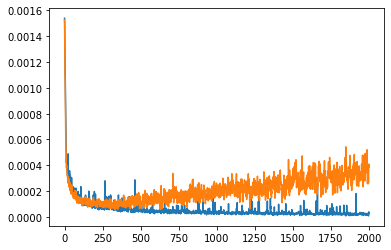

In [5]:
plt.plot(loss_list_nre)
plt.plot(val_loss_list_nre)

#### BNRE

In [6]:
hamiltorch.set_random_seed(0)
estimator_bnre = NRE(D_in, D_out, hidden_features=[hidden_features] * layers, activation=nn.ELU).to(device)
estimator_bnre, loss_list_bnre, val_loss_list_bnre = train_estimator(estimator_bnre, BNRELoss, epochs, dataset, dataset_val, lr, device)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:03<00:00, 16.17epoch/s, loss=4.53e-5, val=0.000403]


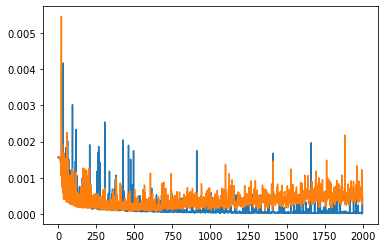

In [7]:
plt.plot(loss_list_bnre)
plt.plot(val_loss_list_bnre)

#### DNRE

In [8]:
hamiltorch.set_random_seed(0)
estimator_dnre = DNRE(D_in, D_out, hidden_features=[hidden_features] * layers, activation=nn.ELU).to(device)
estimator_dnre, loss_list_dnre, val_loss_list_dnre = train_estimator(estimator_dnre, DNRELoss, epochs_dnre, dataset, dataset_val, lr, device)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [12:21<00:00, 13.49epoch/s, loss=2.6e-6, val=2.46e-5]


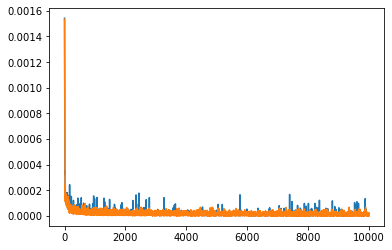

In [9]:
plt.plot(loss_list_dnre)
plt.plot(val_loss_list_dnre)

### Save/Load Models

In [10]:
if save:
    model_list_dic = {'estimator_dnre_state_dict':estimator_dnre.state_dict(),
                      'estimator_nre_state_dict':estimator_nre.state_dict(),
                      'estimator_bnre_state_dict':estimator_bnre.state_dict(),
                      'hidden_features':hidden_features,
                      'D_in':D_in, 'D_out':D_out,
                      'epochs': epochs,
                      'lr': lr}

    torch.save(model_list_dic, '../models/models_qcopter_dict.pt')


if load:
    model_list_dic = torch.load('../models/models_qcopter_dict.pt')
    estimator_nre = NRE(D_in, D_out, hidden_features=[hidden_features] * 5, activation=nn.ELU).to(device)
    estimator_bnre = NRE(D_in, D_out, hidden_features=[hidden_features] * 5, activation=nn.ELU).to(device)
    estimator_dnre = DNRE(D_in, D_out, hidden_features=[hidden_features] * 5, activation=nn.ELU).to(device)



    estimator_nre.load_state_dict(model_list_dic['estimator_nre_state_dict'])
    estimator_bnre.load_state_dict(model_list_dic['estimator_bnre_state_dict'])
    estimator_dnre.load_state_dict(model_list_dic['estimator_dnre_state_dict'])

### Set Observation

In [11]:
x_star = torch.tensor([4, 3, 500, 20, 30, 0.7, 2000])
[print(n + ': ' + str(o.item()) + '\n') for n, o in zip(dic['x_names'], x_star)]

x_star_norm = (x_star - xs_mean)/xs_std

Interferences: 4.0

mass: 3.0

Max_Flight_Distance_(m): 500.0

Max_Hover_Time_(s): 20.0

Max_Lateral_Speed_(m/s): 30.0

Max_uc_at_Max_Flight_Distance: 0.699999988079071

Power_at_Max_Speed_(W): 2000.0



#### Run Random-Walk Metropolis-Hastings

In [12]:
hamiltorch.set_random_seed(0)

samples_nre = mh_nre(estimator_nre, x_star_norm, sigma = 0.5, n_chains = 1024, burn = 1024, n_samples_per_chain = 2048, thinning = 4, prior = prior)

samples_bnre = mh_nre(estimator_bnre, x_star_norm, sigma = 0.5, n_chains = 1024, burn = 1024, n_samples_per_chain = 2048, thinning = 4, prior = prior)

ratio = True
samples_dnre = mh_nre(estimator_dnre.cpu(), x_star_norm, sigma = 0.5, n_chains = 1024, burn = 1024, n_samples_per_chain = 2048, thinning = 4, prior = prior, ratio = ratio)


#### Plot results

In [13]:
hamiltorch.set_random_seed(0)

Names = ['Arm_2159_Length', 'FUSELAGE_HORZ_DIAMETER',
         'FUSELAGE_VERT_DIAMETER', 'FUSELAGE_LENGTH']

names_verbose = [r'Arm L.', r'F. Dim. H.', r'F. Dim. V.', r'F. L.']

indices = [dic['theta_names'].index(n) for n in Names]

def un(x):
    if len(x.shape) > 1:
        return x * thetas_std[indices].view(1,-1) + thetas_mean[indices].view(1,-1)
    else:
        return x * thetas_std[indices] + thetas_mean[indices]

M = 5000

sub_sample_ind = torch.randperm(samples_nre[:, indices].shape[0])[:M]

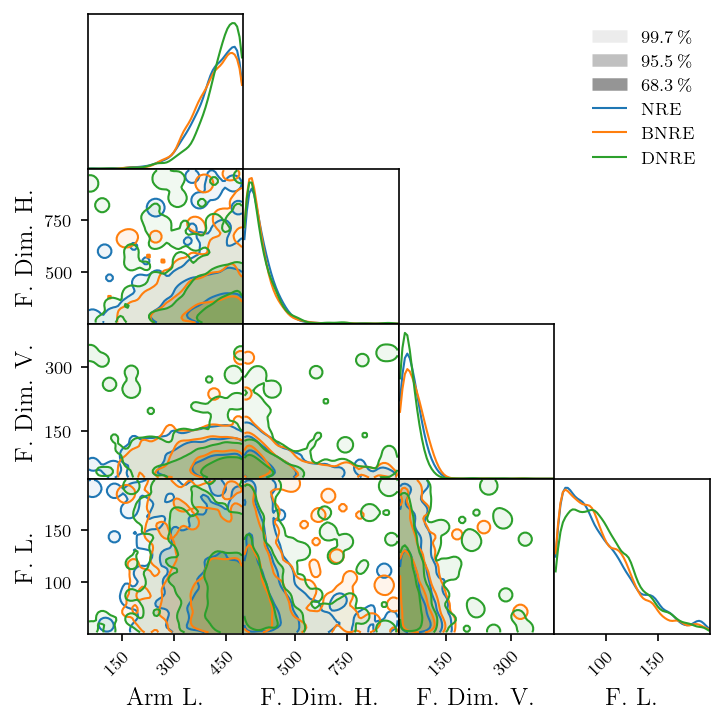

In [14]:
plt.rcParams.update(nice_rc(latex=True))

fig = corner(
    un(samples_nre[sub_sample_ind][:,indices]),
    smooth=2,
    domain=(un(LOWER[indices]), un(UPPER[indices])),
    labels=names_verbose,
    legend=r'NRE',
    figsize=(4.8, 4.8),
    color = 'C0'
)

fig = corner(
    un(samples_bnre[sub_sample_ind][:,indices]),
    smooth=2,
    domain=(un(LOWER[indices]), un(UPPER[indices])),
    labels=names_verbose,
    legend=r'BNRE',
    figsize=(4.8, 4.8),
    figure = fig,
    color = 'C1'
)

fig = corner(
    un(samples_dnre[sub_sample_ind][:,indices]),
    smooth=2,
    domain=(un(LOWER[indices]), un(UPPER[indices])),
    labels=names_verbose,
    legend=r'DNRE',
    figsize=(4.8, 4.8),
    figure = fig,
    color = 'C2'
)